In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import plot.viz_sequence as viz_sequence
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [2]:
model_type = "profile"

In [3]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000

In [4]:
# SPI1
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/SPI1/SPI1_training_paths.json" % model_type)
num_tasks = 4
num_strands = 2
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_base_path = os.path.join(model_base_path, "SPI1/")
prior_model_base_path = os.path.join(model_base_path, "SPI1_prior/")

In [29]:
# GATA2
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/GATA2/GATA2_training_paths.json" % model_type)
num_tasks = 3
num_strands = 2
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_base_path = os.path.join(model_base_path, "GATA2/")
prior_model_base_path = os.path.join(model_base_path, "GATA2_prior/")

In [ ]:
# K562
files_spec_path = os.path.join(data_base_path, "ENCODE_DNase/%s/config/K562/K562_training_paths.json" % model_type)
num_tasks = 1
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_base_path = os.path.join(model_base_path, "K562_keep1/")
prior_model_base_path = os.path.join(model_base_path, "K562_prior_keep1/")

In [33]:
# BPNet
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(data_base_path, "BPNet_ChIPseq/%s/config/BPNet_training_paths.json" % model_type)
num_tasks = 1
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_base_path = os.path.join(model_base_path, "BPNet/")
prior_model_base_path = os.path.join(model_base_path, "BPNet_prior/")

In [5]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Determine which epochs from all runs to use

In [7]:
def import_metrics_json(model_base_path, run_num):
    """
    Looks in {model_base_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(model_base_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [8]:
def get_model_paths(
    model_base_path, metric_name="val_prof_corr_losses",
    reduce_func=(lambda values: np.mean(values)), compare_func=(lambda x, y: x < y),
    print_found_values=True
):
    """
    Looks in `model_base_path` and for each run, returns the full path to
    the best epoch. By default, the best epoch in a run is determined by
    the lowest validation profile loss.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(model_base_path, run_num) for run_num in os.listdir(model_base_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    model_paths = []
    for run_num in sorted(metrics.keys(), key=lambda x: int(x)):
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            model_path = os.path.join(model_base_path, run_num, "model_ckpt_epoch_%d.pt" % best_epoch_in_run)
            model_paths.append(model_path)
            if print_found_values:
                print("\tRun %s, epoch %d: %6.2f" % (run_num, best_epoch_in_run, best_val_in_run))
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return model_paths
        

In [9]:
metric_name = "val_prof_corr_losses" if model_type == "profile" else "val_corr_losses"

In [11]:
noprior_model_paths = get_model_paths(noprior_model_base_path, metric_name=metric_name)

	Run 1, epoch 16:  86.15
	Run 2, epoch 12:  85.34
	Run 3, epoch 20:  85.61
	Run 4, epoch 19:  85.28
	Run 5, epoch 12:  85.41
	Run 6, epoch 15:  85.37
	Run 7, epoch 15:  85.71
	Run 8, epoch 14:  85.46
	Run 9, epoch 12:  85.15
	Run 10, epoch 17:  85.84
	Run 11, epoch 14:  85.97
	Run 12, epoch 16:  85.92
	Run 13, epoch 16:  85.33
	Run 14, epoch 3:  86.03


In [14]:
prior_model_paths = get_model_paths(prior_model_base_path, metric_name=metric_name)

	Run 1, epoch 12:  85.86
	Run 2, epoch 17:  85.24
	Run 3, epoch 17:  86.15
	Run 4, epoch 10:  85.89
	Run 5, epoch 16:  85.78
	Run 6, epoch 16:  85.56


In [15]:
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

### Data preparation
Create an input data loader, that maps coordinates or bin indices to data needed for the model

In [16]:
if model_type == "profile":
    input_func = data_loading.get_profile_input_func(
        files_spec_path, input_length, profile_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_profile_coords(
        files_spec_path, chrom_set=chrom_set
    )
else:
    input_func = data_loading.get_binary_input_func(
        files_spec_path, input_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_binary_bins(
        files_spec_path, chrom_set=chrom_set
    )

### Compute consistency

In [23]:
# Pick a sample of 100 random coordinates/bins
num_samples = 100
sample = pos_examples[np.random.choice(len(pos_examples), size=num_samples, replace=False)]

In [24]:
def compute_gradients(model_paths, sample):
    """
    Given a list of paths to M models and a list of N coordinates or bins, computes
    the input gradients over all models, returning an M x N x I x 4 array of
    gradient values and an N x I x 4 array of one-hot encoded sequence.
    """
    num_models, num_samples = len(model_paths), len(sample)
    
    all_input_grads = np.empty((num_models, num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
    
    for i in tqdm.notebook.trange(num_models):
        model = restore_model(model_paths[i])
            
        if model_type == "profile":
            results = compute_predictions.get_profile_model_predictions(                                              
                model, sample, num_tasks, input_func, controls=controls,                        
                return_losses=False, return_gradients=True, show_progress=False                                         
            )
        else:
            results = compute_predictions.get_binary_model_predictions(                                              
                model, sample, input_func,                      
                return_losses=False, return_gradients=True, show_progress=False                                         
            )

        all_input_grads[i] = results["input_grads"]
        if i == 0:
            all_one_hot_seqs = results["input_seqs"]
    return all_input_grads, all_one_hot_seqs

In [20]:
def compute_shap_scores(model_paths, sample, batch_size=128):
    """
    Given a list of paths to M models and a list of N coordinates or bins, computes
    the SHAP scores over all models, returning an M x N x I x 4 array of
    SHAP scores and an N x I x 4 array of one-hot encoded sequence.
    """
    num_models, num_samples = len(model_paths), len(sample)
    
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_models, num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
    
    for i in tqdm.notebook.trange(num_models):
        model = restore_model(model_paths[i])
        
        if model_type == "profile":
            shap_explainer = compute_shap.create_profile_explainer(
                model, input_length, profile_length, num_tasks, num_strands, controls
            )
        else:
            shap_explainer = compute_shap.create_binary_explainer(
                model, input_length
            )

        for j in range(num_batches):
            batch_slice = slice(j * batch_size, (j + 1) * batch_size)
            batch = sample[batch_slice]
            
            if model_type == "profile":
                input_seqs, profiles = input_func(sample)
                shap_scores = shap_explainer(
                    input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
                )
            else:
                input_seqs, _, _ = input_func(sample)
                shap_scores = shap_explainer(
                    input_seqs, hide_shap_output=True
                )
            
            all_shap_scores[i, batch_slice] = shap_scores
            if i == 0:
                all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [33]:
# Compute the importance scores and 1-hot seqs
noprior_scores, _ = compute_shap_scores(noprior_model_paths, sample)
prior_scores, one_hot_seqs = compute_shap_scores(prior_model_paths, sample)

In [ ]:
# Plot out a few examples over some different models
center_slice = slice(600, 700)
for i in np.random.choice(num_samples, size=3, replace=False):
    print(sample[i])
    print("=========================")
    print("Without priors:")
    print("---------------")
    for j in np.random.choice(len(noprior_model_paths), size=3, replace=False):
        print("Model %d" % (j + 1))
        viz_sequence.plot_weights(noprior_scores[j, i, center_slice] * one_hot_seqs[i, center_slice])
    print("With priors:")
    print("------------")
    for j in np.random.choice(len(prior_model_paths), size=3, replace=False):
        print("Model %d" % (j + 1))
        viz_sequence.plot_weights(prior_scores[j, i, center_slice] * one_hot_seqs[i, center_slice])

In [26]:
def cont_jaccard(seq_1, seq_2):
    """
    Takes two gradient sequences (I x 4 arrays) and computes a similarity between
    them, using a continuous Jaccard metric.
    """
    ab_1, ab_2 = np.abs(seq_1), np.abs(seq_2)
    inter = np.minimum(ab_1, ab_2) * np.sign(seq_1) * np.sign(seq_2)
    union = np.maximum(ab_1, ab_2)
    cont_jaccard = np.sum(inter, axis=1) / np.sum(union, axis=1)
    return np.sum(cont_jaccard)

In [27]:
def cosine_sim(seq_1, seq_2):
    """
    Takes two gradient sequences (I x 4 arrays) and computes a similarity between
    them, using a cosine similarity.
    """
    seq_1, seq_2 = np.ravel(seq_1), np.ravel(seq_2)
    dot = np.sum(seq_1 * seq_2)
    mag_1, mag_2 = np.sqrt(np.sum(seq_1 * seq_1)), np.sqrt(np.sum(seq_2 * seq_2))
    return dot / (mag_1 * mag_2)

In [28]:
def compute_similarity_matrix(input_grads, sim_func=cosine_sim):
    """
    Given the M x N x I x 4 input gradients returned by `compute_gradients`,
    computes an N x M x M similarity matrix of similarity across models (i.e.
    each coordinate gets a similarity matrix across different models).
    By defaults uses the continuous Jaccard similarity score
    """
    num_models, num_coords = input_grads.shape[0], input_grads.shape[1]
    
    sim_mats = np.empty((num_coords, num_models, num_models))
    for i in tqdm.notebook.trange(num_coords):
        for j in range(num_models):
            sim_mats[i, j, j] = 0
            for k in range(j):
                sim_score = sim_func(input_grads[j][i], input_grads[k][i])
                sim_mats[i, j, k] = sim_score
                sim_mats[i, k, j] = sim_score
    return sim_mats

In [34]:
noprior_sim_matrix = compute_similarity_matrix(noprior_scores, sim_func=cosine_sim)
prior_sim_matrix = compute_similarity_matrix(prior_scores, sim_func=cosine_sim)

Average similarity without priors: 0.748227
Average similarity with priors: 0.918189
One-sided t-test p: 0.000000


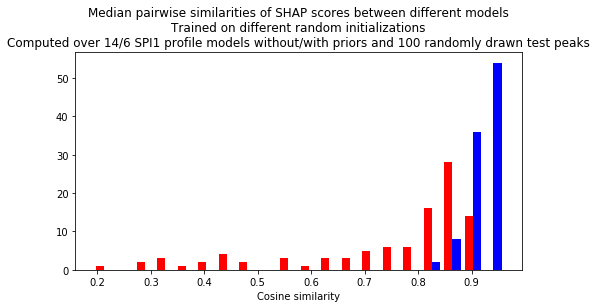

In [36]:
noprior_avg_sims, prior_avg_sims = [], []
bin_num = 20
for i in range(num_samples):
    noprior_avg_sims.append(np.median(noprior_sim_matrix[i][np.tril_indices(len(noprior_model_paths), k=-1)]))
    prior_avg_sims.append(np.median(prior_sim_matrix[i][np.tril_indices(len(prior_model_paths), k=-1)]))
plt.figure(figsize=(8, 4))
plt.hist(
    [noprior_avg_sims, prior_avg_sims],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"]
)
plt.title(
    "Median pairwise similarities of SHAP scores between different models" +
    "\nTrained on different random initializations" +
    "\nComputed over %d/%d SPI1 profile models without/with priors and %d randomly drawn test peaks" % (len(noprior_model_paths), len(prior_model_paths), num_samples)
)
plt.xlabel("Cosine similarity")

print("Average similarity without priors: %f" % np.nanmean(noprior_avg_sims))
print("Average similarity with priors: %f" % np.nanmean(prior_avg_sims))
t, p = scipy.stats.ttest_ind(prior_avg_sims, noprior_avg_sims)
print("One-sided t-test p: %f" % (p / 2))